In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')
import anuga

# Cargado de datos

In [2]:
''' PARÁMETROS '''

# ARCHIVOS
# INPUT_FOLDER = "C:/Users/JorgeOvalle/Desktop/Proyecto Relaves/data_descargas/input"
INPUT_FOLDER = os.path.abspath("input")
CICLO = 9
SECTORES = [5, 6]

# PARÁMETROS DE SIMULACIÓN
MANNING = 0.025
G = 2.7
C_p = 0.499
    

folder_ciclo = os.path.join(INPUT_FOLDER, f"ciclo_{CICLO}")

In [3]:
# DESCARGAS

suffix_input = '_'.join([str(s) for s in SECTORES])
df_descargas = pd.read_csv(os.path.join(folder_ciclo, "input_sectores_{}.csv".format(suffix_input)), parse_dates=['fecha'])

In [17]:
# POLIGONOS
poligono_sector_5 = anuga.read_polygon(os.path.join(folder_ciclo,'poligono_sector_5_extendido.csv'))
poligono_sector_6 = anuga.read_polygon(os.path.join(folder_ciclo,'poligono_sector_6.csv'))
zona_interior_sector_5 = anuga.read_polygon(os.path.join(folder_ciclo,'zona_interior_sector_5.csv'))
zona_interior_sector_6 = anuga.read_polygon(os.path.join(folder_ciclo,'zona_interior_sector_6.csv'))

# ARCHIVO TOPO
archivo_topo = os.path.join(folder_ciclo, "DEM_04.02.2023_10x10m.asc")

# RESOLUCIONES
poligono_res = 100
zona_interior_res = 50

# REGIONES_INTERIORES
region_interior_sector_5 = [[zona_interior_sector_5, zona_interior_res]]
region_interior_sector_6 = [[zona_interior_sector_6, zona_interior_res]]

In [5]:
poligono_sector_5 = [[poligono_sector_5, poligono_res]]

In [23]:
len(poligono_sector_5)

4

# Creación de dominio para descargas del sector 5

In [25]:
domain = anuga.create_domain_from_regions(poligono_sector_5, 
                                          boundary_tags={'l1': [0], 'l2': [1], 'l3': [2], 'l4': [3]}, 
                                          maximum_triangle_area=poligono_res,
                                          interior_regions=region_interior_sector_5)
domain.set_name('relaves_sector_5') # Nombre del archivo de salida
dplotter = anuga.Domain_plotter(domain, plot_dir='figuras_sector_5') # Carpeta de salida de las figuras

Figure files for each frame will be stored in figuras_sector_5


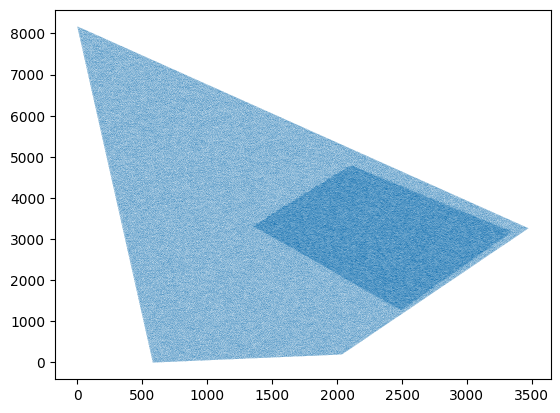

In [40]:
# Graficamos
plt.triplot(dplotter.triang, linewidth = 0.07)

# Condiciones iniciales

In [26]:
domain.set_quantity('elevation', filename=archivo_topo, location='centroids') # Use function for elevation
domain.set_quantity('friction', MANNING, location='centroids')                        # Constant friction 
domain.set_quantity('stage', expression='elevation', location='centroids')

Text(0.5, 1.0, 'Elevation')

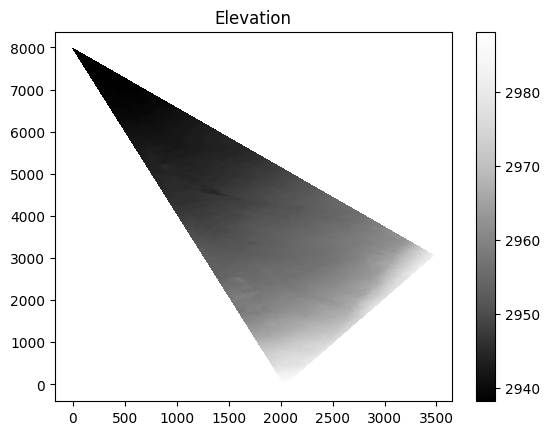

In [9]:
plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='Greys_r')
plt.colorbar()
plt.title("Elevation")

In [27]:
Bt = anuga.Transmissive_boundary(domain)
domain.set_boundary({'l1': Bt, 'l2': Bt, 'l3': Bt, 'l4': Bt})

# Operadores Inlet

In [28]:
def calcular_caudal(tasa_masa_seca: float):
    q = tasa_masa_seca * (C_p + G * (1 - C_p)) / (C_p * G)
    return q

def calcular_velocidad_inicial(tasa_masa_seca: float, radio_canaleta: float, angulo_polar: float):
    q = calcular_caudal(tasa_masa_seca)
    rapidez = 2*q / (np.pi * radio_canaleta**2)
    return rapidez * np.array([np.sin(angulo_polar), np.cos(angulo_polar)])

In [29]:
# Descarga sector 5 día 1
df_descargas_sector_5 = df_descargas[df_descargas.sector == 5]
df_descargas_sector_5 = df_descargas_sector_5[df_descargas_sector_5.fecha == df_descargas_sector_5.fecha.min()]

In [30]:
df_descargas_sector_5

,fecha,sector,id_punto,coordenada_x,coordenada_y,angulo_polar,tms,tasa_diaria,radio_canaleta
153,2023-03-02,5,29,489215.492474,7.297292e+06,2.425051,22137.258627,0.961598,1.6345
154,2023-03-02,5,32,489082.721325,7.296706e+06,2.536601,22137.258627,0.961598,1.4370
155,2023-03-02,5,33,488926.557163,7.296312e+06,2.907850,22137.258627,0.961598,1.6430
156,2023-03-02,5,37,488770.083732,7.295805e+06,2.377836,44274.517254,1.923196,1.3145


In [31]:
# Creamos las distintas regiones para establecer canaletas de salida
operadores_inlet = []

for index, row in df_descargas_sector_5.iterrows():
    center = (row.coordenada_x, row.coordenada_y)
    radius = row.radio_canaleta

    while True:
        try:
            region = anuga.Region(domain, center=center, radius=radius)
            break
        except:
            radius += 1
            print("Error, aumentando radio")

    canaleta = anuga.Inlet_operator(domain, region=region, 
                                    Q=calcular_caudal(row.tasa_diaria),
                                    velocity=calcular_velocidad_inicial(row.tasa_diaria, row.radio_canaleta, row.angulo_polar))
    operadores_inlet.append(canaleta)


Error, aumentando radio
Error, aumentando radio
Error, aumentando radio
Error, aumentando radio
Error, aumentando radio


In [44]:
region.areas[region.get_indices()].sum()

29.559254290768877

In [45]:
df_descargas_sector_5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 153 to 156
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   fecha           4 non-null      datetime64[ns]
 1   sector          4 non-null      int64         
 2   id_punto        4 non-null      int64         
 3   coordenada_x    4 non-null      float64       
 4   coordenada_y    4 non-null      float64       
 5   angulo_polar    4 non-null      float64       
 6   tms             4 non-null      float64       
 7   tasa_diaria     4 non-null      float64       
 8   radio_canaleta  4 non-null      float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 320.0 bytes


In [56]:
t_inlet_max = (df_descargas_sector_5.tms / df_descargas_sector_5.tasa_diaria).max()
if t_inlet_max % 400 < 20:
    t_inlet_max = (t_inlet_max // 400 + 1) * 400


In [48]:
yieldstep = 400
t_inlet_max = 1610
fracc = (t_inlet_max % yieldstep) / yieldstep
print(fracc)
if fracc < 0.05:
    t_inlet_max = (t_inlet_max // yieldstep) * yieldstep

0.025


In [50]:
canaleta = operadores_inlet[0]

In [52]:
canaleta.get_Q()

1.3215996014679452

In [53]:
calcular_caudal(df_descargas_sector_5.tasa_diaria.iloc[0])

1.3215996014679452

In [57]:
inlets_activados = True
for t in domain.evolve(yieldstep=400, duration=t_inlet_max + 1600):
  
    #dplotter.plot_depth_frame()
    dplotter.save_depth_frame()
    
    if inlets_activados and t >= t_inlet_max:
        for op in operadores_inlet:
            op.set_Q(0)
        inlets_activados = False
    
    domain.print_timestepping_statistics()


Time = 0.0000 (sec), steps=0 (2187s)
Time = 400.0000 (sec), delta t = 1000.00000000 (s), steps=1 (2s)
Time = 800.0000 (sec), delta t in [0.07178085, 0.45539220] (s), steps=1009 (97s)
Time = 1200.0000 (sec), delta t in [0.36994838, 0.41913881] (s), steps=975 (86s)
Time = 1600.0000 (sec), delta t in [0.35817958, 0.42201924] (s), steps=975 (100s)
Time = 2000.0000 (sec), delta t in [0.36557836, 0.42011705] (s), steps=975 (88s)
Time = 2400.0000 (sec), delta t in [0.36395004, 0.42052042] (s), steps=975 (87s)
Time = 2800.0000 (sec), delta t in [0.36464015, 0.42034706] (s), steps=975 (84s)
Time = 3200.0000 (sec), delta t in [0.36450377, 0.42038072] (s), steps=975 (90s)
Time = 3600.0000 (sec), delta t in [0.36458351, 0.42036064] (s), steps=975 (132s)
Time = 4000.0000 (sec), delta t in [0.36457945, 0.42036155] (s), steps=975 (102s)
Time = 4400.0000 (sec), delta t in [0.36459295, 0.42035812] (s), steps=975 (93s)
Time = 4800.0000 (sec), delta t in [0.36459652, 0.42035718] (s), steps=975 (94s)
Time

: 

In [ ]:
dplotter.make_depth_animation(vmin=0, vmax=2.5) 